<a href="https://colab.research.google.com/github/chinmay-routray-github/Image_Classifiers/blob/main/CIFAR10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting the pre-requisited

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt


Setting the Hyper-parameters

In [20]:
num_epochs = 15
batch_size = 12
learning_rate = 0.002


In [3]:

# If you have NVDIA gpu
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device = torch.device('cpu')

# Normailzing each PILImage
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# loading the CIFAR10 training and testing dataset
# CIFAR10 : 60000 color images of size 32x32 and 10 classes, 6000 images per class

train_data = torchvision.datasets.CIFAR10(root='./data', download = True,
                                          train = True, transform = transform)

test_data = torchvision.datasets.CIFAR10(root ='./data', train = False,
                                         download = True, transform = transform)

# labels
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = DataLoader(dataset = train_data, batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_data, batch_size=batch_size,
                         shuffle = False)



100%|██████████| 170498071/170498071 [00:05<00:00, 29268745.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Verifying the training set by showing images

In [4]:
def imgshow(img):
  img = img/2 +0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

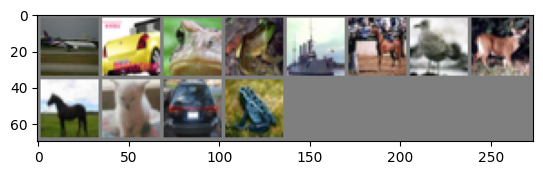

In [5]:
dataiter = iter(train_loader)
image, label = next(dataiter)
imgshow(torchvision.utils.make_grid(image))

Designing the CNN

<h3>Image size, CxHxW = 3x32x32 </h3>
<br>
size after convolution 1, w_out = (W - F + 2P)/S + 1 <br>
          number of kernels = 6, padding = 0, size of kernel = 5x5, stride = 1 <br>
          size = 6x28x28 <br>
size after pooling 1, w_out = (W - F)/S + 1 <br>
          size of kernel = 2x2, stride = 2 <br>
          size = 6x14x14 <br>

size after convolution 2, w_out = (W - F + 2P)/S + 1 <br>
          number of kernels = 16, padding = 0, size of kernel = 5x5, stride = 1 <br>
          size = 16x10x10 <br>
size after pooling 2, w_out = (W - F)/S + 1<br>
          size of kernel = 2x2, stride = 2 <br>
          size = 16x5x5 <br>
          
Then, flattening and feeding to fully-connected layers.

In [6]:

class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x_in):

    # first convolution-pooling layer
    out = self.pool(F.relu(self.conv1(x_in)))

    # second convolution-pooling layer
    out = self.pool(F.relu(self.conv2(out)))

    out = out.view(-1, 16*5*5)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

Training the model

In [21]:

model = ConvNet().to(device)
cost_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
total_steps = len(train_loader)

x = []
y = []
n_p = 0
# training the model
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # forward propagation
    pred = model(images)
    loss = cost_f(pred, labels)

    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if((i+1) % 2000 == 0):
      n_p += 1
      print(f"Epochs : {epoch+1}/{num_epochs},          Step : {i+1}/{total_steps},         loss : {loss.item():.6f}")
      y.append(loss.item())
      x.append((n_p))

print("training complete... Plotting loss ~ no. of steps/epoch")


print("...Saving the file...")
FILE = 'CIFAR10_model.pth'
data = {}
data['model_state'] = model.state_dict()
data['conv1'] = model.conv1
data['conv2'] = model.conv2
data['pool'] = model.pool
data['fc1'] = model.fc1
data['fc2'] = model.fc2
data['fc3'] = model.fc3
torch.save(data, FILE)
print(f"file saved to {FILE}")


Epochs : 1/15,          Step : 2000/4167,         loss : 2.310642
Epochs : 1/15,          Step : 4000/4167,         loss : 2.297197
Epochs : 2/15,          Step : 2000/4167,         loss : 2.213476
Epochs : 2/15,          Step : 4000/4167,         loss : 2.064174
Epochs : 3/15,          Step : 2000/4167,         loss : 1.923760
Epochs : 3/15,          Step : 4000/4167,         loss : 1.807667
Epochs : 4/15,          Step : 2000/4167,         loss : 1.601023
Epochs : 4/15,          Step : 4000/4167,         loss : 1.254281
Epochs : 5/15,          Step : 2000/4167,         loss : 1.515164
Epochs : 5/15,          Step : 4000/4167,         loss : 1.503271
Epochs : 6/15,          Step : 2000/4167,         loss : 1.632219
Epochs : 6/15,          Step : 4000/4167,         loss : 1.193873
Epochs : 7/15,          Step : 2000/4167,         loss : 1.259772
Epochs : 7/15,          Step : 4000/4167,         loss : 1.612924
Epochs : 8/15,          Step : 2000/4167,         loss : 1.366421
Epochs : 8

Text(0, 0.5, 'cost function')

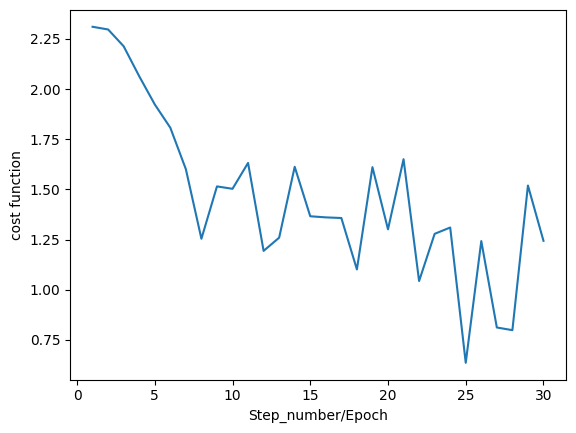

In [22]:
# plotting the loss
plt.plot(x, y)
plt.xlabel("Step_number/Epoch")
plt.ylabel('cost function')

In [24]:

# Prediction from a 32x32 PILImage
def predict(image_tensor, classes):
  image_tensor = image_tensor.to(device)

  g = torch.softmax(model(image_tensor), dim=1)
  pred = []
  for i in g:
    i = i.tolist()
    pred.append(i.index(max(i)))
  return [classes[j] for j in pred]

# loading the trained model
data = torch.load(FILE)
model_state = data['model_state']
model = ConvNet().to(device)
model.load_state_dict(model_state)
model.eval()
predict(image, classes)

['plane',
 'ship',
 'dog',
 'frog',
 'ship',
 'horse',
 'truck',
 'frog',
 'horse',
 'dog',
 'car',
 'bird']

In [25]:

# validating the predictions
for (img, lab) in test_loader:
  print(img.shape , lab)
  print(torch.max(torch.softmax(model(img), dim=1), 1))
  break


torch.Size([12, 3, 32, 32]) tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9])
torch.return_types.max(
values=tensor([0.5848, 0.4618, 0.6408, 0.8095, 0.5674, 0.7403, 0.3589, 0.6711, 0.3963,
        0.7861, 0.4440, 0.8496], grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 8, 8, 6, 6, 5, 6, 3, 1, 0, 9]))


In [23]:

# Finding the accuracy of model
with torch.no_grad():
  n_samples = 0
  n_correct = 0
  for epoch in range(num_epochs):
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      prediction = torch.max(torch.softmax(model(images), dim=1), 1)[1]
      # prediction, labels are both tensors
      n_correct += (prediction == labels).sum().item()
      n_samples += labels.size(0)

  print("...finding the accuracy...")
  # calculating accuracy
  acc = n_correct/n_samples*100
  print(f"accuarcy : {acc:.4f} %")
  print(f"no. of samples = {n_samples}")
  print(f"correct predictions : = {n_correct}")


...finding the accuracy...
accuarcy : 58.0400 %
no. of samples = 150000
correct predictions : = 87060


Resources :

1 - https://www.youtube.com/watch?v=pDdP0TFzsoQ&t=21s&ab_channel=PatrickLoeber

2 - https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

3 - https://www.youtube.com/watch?v=d9QHNkD_Pos&ab_channel=freeCodeCamp.org